In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

MANIFEST_PATH = "../../dataset/split_dataset/manifests/split_manifest.csv"

df = pd.read_csv(MANIFEST_PATH)
print("Total samples:", len(df))


Total samples: 20


In [ ]:
df.head()

,index,split,label,manufacturer,src_path,split_path,width,height,age_years,view_position
0,0,train,TB,SIEMENS,../../dataset/curated/TB/dicom-study-231027000...,../../dataset/split_dataset/train/TB/dicom-stu...,2208,2020,46.0,NaN
1,1,val,TB,SIEMENS,../../dataset/curated/TB/dicom-study-231023003...,../../dataset/split_dataset/val/TB/dicom-study...,1944,2170,57.0,NaN
2,2,train,TB,SIEMENS,../../dataset/curated/TB/dicom-study-231020002...,../../dataset/split_dataset/train/TB/dicom-stu...,2076,2414,22.0,NaN
3,3,train,TB,SIEMENS,../../dataset/curated/TB/dicom-study-231019006...,../../dataset/split_dataset/train/TB/dicom-stu...,1984,2039,19.0,NaN
4,4,test,TB,FUJIFILM CORPORATION,../../dataset/curated/TB/pacs_rslt-dicom-study...,../../dataset/split_dataset/test/TB/pacs_rslt-...,2336,2836,44.0,NaN


In [28]:
split_label_counts = (
    df.groupby(["split", "label"])
      .size()
      .reset_index(name="count")
)

split_label_counts


,split,label,count
0,test,NonTB,2
1,test,TB,2
2,train,NonTB,7
3,train,TB,5
4,val,NonTB,2
5,val,TB,2


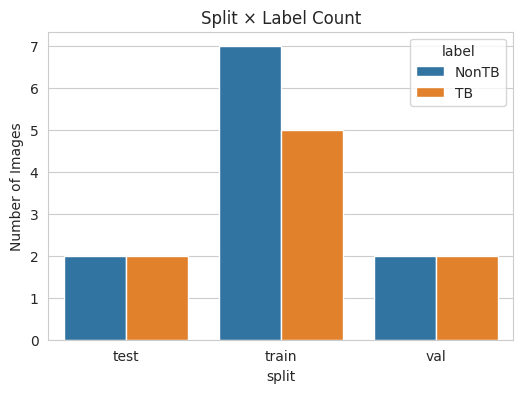

In [29]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=split_label_counts,
    x="split",
    y="count",
    hue="label"
)
plt.title("Split × Label Count")
plt.ylabel("Number of Images")
plt.show()


In [30]:
counts = df.groupby(["split", "label"]).size().reset_index(name="count")
totals = df.groupby("split").size().reset_index(name="total")
label_prop = pd.merge(counts, totals, on="split")
label_prop["proportion"] = label_prop["count"] / label_prop["total"]

print(label_prop)

   split  label  count  total  proportion
0   test  NonTB      2      4    0.500000
1   test     TB      2      4    0.500000
2  train  NonTB      7     12    0.583333
3  train     TB      5     12    0.416667
4    val  NonTB      2      4    0.500000
5    val     TB      2      4    0.500000


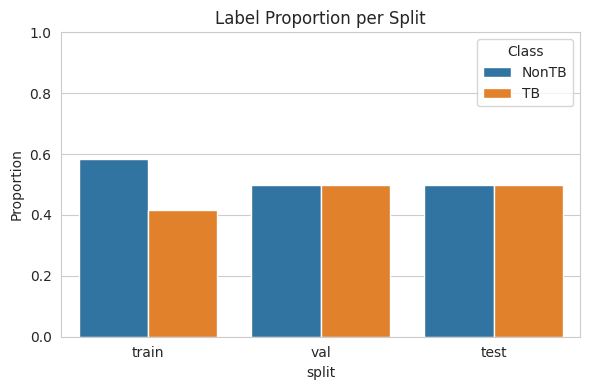

In [31]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=label_prop,
    x="split",
    y="proportion",
    hue="label",
    order=["train", "val", "test"] 
)

plt.title("Label Proportion per Split")
plt.ylabel("Proportion")
plt.ylim(0, 1.0) 
plt.legend(title='Class')
plt.tight_layout()
plt.show()

In [32]:
manufacturer_split = (
    df.groupby(["manufacturer", "split"])
      .size()
      .reset_index(name="count")
)

manufacturer_split.head()


,manufacturer,split,count
0,FUJIFILM CORPORATION,test,3
1,FUJIFILM CORPORATION,train,6
2,FUJIFILM CORPORATION,val,3
3,SIEMENS,test,1
4,SIEMENS,train,6


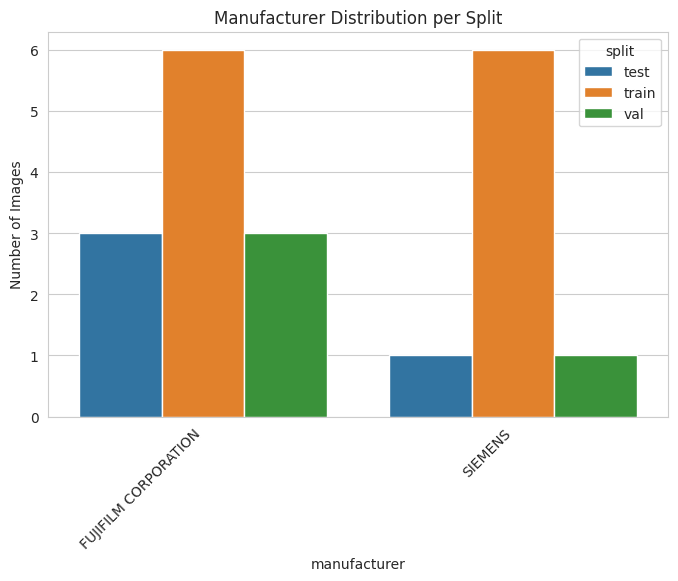

In [33]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=manufacturer_split,
    x="manufacturer",
    y="count",
    hue="split"
)
plt.xticks(rotation=45, ha="right")
plt.title("Manufacturer Distribution per Split")
plt.ylabel("Number of Images")
plt.show()


In [34]:
m_l_s = (
    df.groupby(["manufacturer", "label", "split"])
      .size()
      .reset_index(name="count")
)

m_l_s


,manufacturer,label,split,count
0,FUJIFILM CORPORATION,NonTB,test,2
1,FUJIFILM CORPORATION,NonTB,train,5
2,FUJIFILM CORPORATION,NonTB,val,2
3,FUJIFILM CORPORATION,TB,test,1
4,FUJIFILM CORPORATION,TB,train,1
5,FUJIFILM CORPORATION,TB,val,1
6,SIEMENS,NonTB,train,2
7,SIEMENS,TB,test,1
8,SIEMENS,TB,train,4
9,SIEMENS,TB,val,1


/tmp/ipykernel_3739/4106022846.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


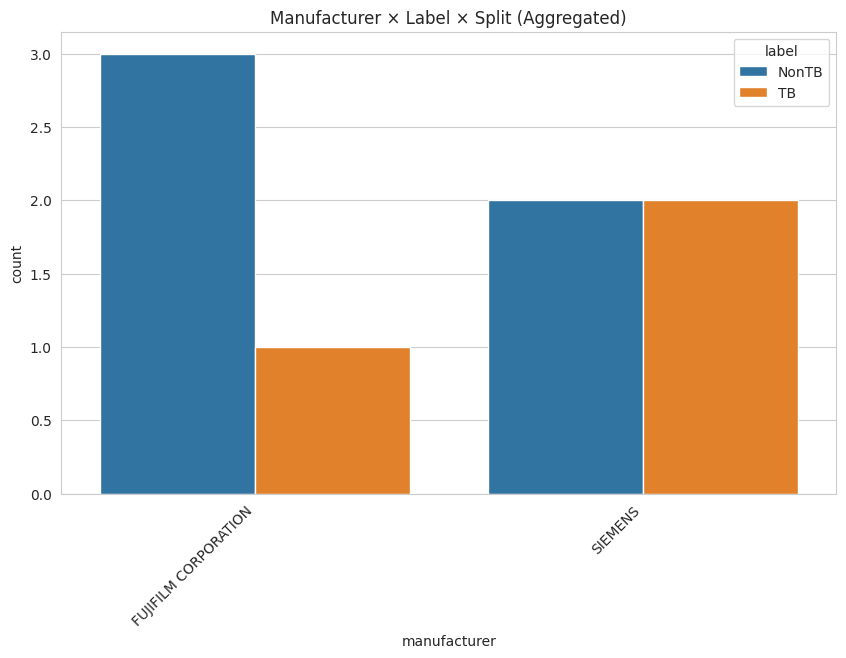

In [35]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=m_l_s,
    x="manufacturer",
    y="count",
    hue="label",
    ci=None
)
plt.xticks(rotation=45, ha="right")
plt.title("Manufacturer × Label × Split (Aggregated)")
plt.show()


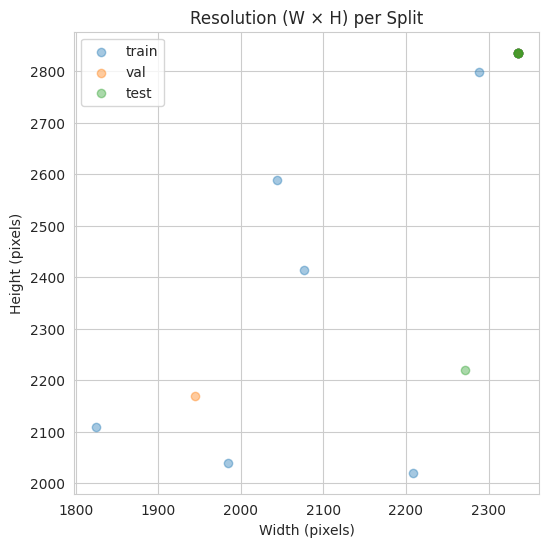

In [36]:
assert "width" in df.columns and "height" in df.columns, \
    "width & height not found in manifest"
    
plt.figure(figsize=(6,6))
for split in df["split"].unique():
    subset = df[df["split"] == split]
    plt.scatter(
        subset["width"],
        subset["height"],
        alpha=0.4,
        label=split
    )

plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.title("Resolution (W × H) per Split")
plt.legend()
plt.show()


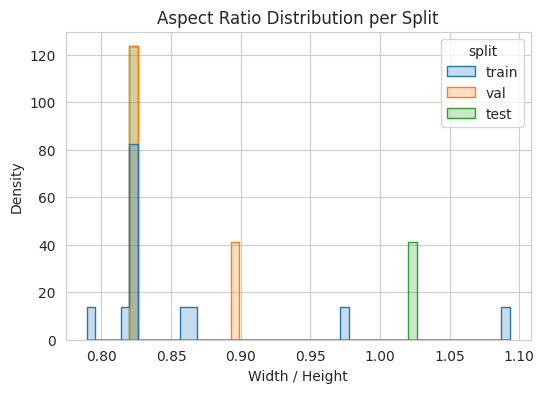

In [37]:
df["aspect_ratio"] = df["width"] / df["height"]
plt.figure(figsize=(6,4))
sns.histplot(
    data=df,
    x="aspect_ratio",
    hue="split",
    bins=50,
    element="step",
    stat="density",
    common_norm=False
)
plt.title("Aspect Ratio Distribution per Split")
plt.xlabel("Width / Height")
plt.show()


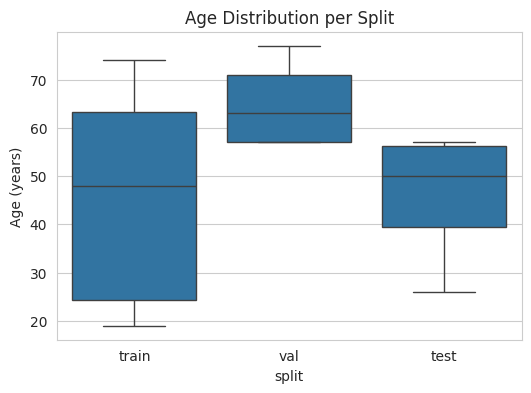

In [39]:
assert "age_years" in df.columns, \
    "age_years not found in manifest"
plt.figure(figsize=(6,4))
sns.boxplot(
    data=df,
    x="split",
    y="age_years"
)
plt.title("Age Distribution per Split")
plt.ylabel("Age (years)")
plt.show()


In [40]:
overlap_found = False

for s1 in df["split"].unique():
    for s2 in df["split"].unique():
        if s1 >= s2:
            continue

        set1 = set(df[df["split"] == s1]["src_path"])
        set2 = set(df[df["split"] == s2]["src_path"])

        overlap = set1.intersection(set2)
        if overlap:
            overlap_found = True
            print(f"Overlap between {s1} and {s2}: {len(overlap)}")

if not overlap_found:
    print("✅ No overlap found between splits.")


✅ No overlap found between splits.


In [41]:
print("===== EDA SPLIT SUMMARY =====")
print("Total samples:", len(df))
print("\nSplit × Label:")
print(df.groupby(["split", "label"]).size())

print("\nUnique manufacturers per split:")
print(df.groupby("split")["manufacturer"].nunique())

print("\nResolution range per split:")
print(
    df.groupby("split")[["width", "height"]]
      .agg(["min", "max"])
)


===== EDA SPLIT SUMMARY =====
Total samples: 20

Split × Label:
split  label
test   NonTB    2
       TB       2
train  NonTB    7
       TB       5
val    NonTB    2
       TB       2
dtype: int64

Unique manufacturers per split:
split
test     2
train    2
val      2
Name: manufacturer, dtype: int64

Resolution range per split:
      width       height      
        min   max    min   max
split                         
test   2272  2336   2219  2836
train  1824  2336   2020  2836
val    1944  2336   2170  2836
